In [1]:
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import datetime
import os

def load():
    data_dir = os.path.abspath("../data/data_v3") + "\\"
    data = {}
    data["deliveries"] = pd.read_json(data_dir + "deliveries.jsonl", lines = True)
    data["sessions"] = pd.read_json(data_dir + "sessions.jsonl", lines = True)
    data["products"] = pd.read_json(data_dir + "products.jsonl", lines = True)
    data["users"] = pd.read_json(data_dir + "users.jsonl", lines = True)
    return data

def preprocess_time(deliveries: pd.DataFrame):
    deliveries["purchase_timestamp"] = pd.to_datetime ( deliveries["purchase_timestamp"], format='%Y-%m-%dT%H:%M', errors="coerce")
    deliveries['delivery_timestamp'] = pd.to_datetime ( deliveries["delivery_timestamp"], format='%Y-%m-%dT%H:%M:%S', errors="coerce")
    return deliveries


def merge(data: {}) -> pd.DataFrame:
    s = data["sessions"]
    d = data["deliveries"]
    p = data["products"]
    u = data["users"]
    purchases = s[s["purchase_id"].notnull()].copy()
    merged = pd.merge(purchases, d, on='purchase_id', how = "outer")
    merged2 = pd.merge(merged, u, on="user_id", how = "outer")
    merged_full = pd.merge(merged2, p, on="product_id", how = "left")
    return merged_full

def select_columns (merged):
    to_select = ["product_id", "offered_discount", "purchase_timestamp", "delivery_timestamp", "delivery_company", "city", "street", "product_name", "category_path", "price"]
    return merged[to_select]

In [30]:
# load data, make sure timestamps are of datetime type and merge data
data = load()
data["deliveries"] = preprocess_time(data["deliveries"])
merged = merge(data)
merged.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,name,city,street,product_name,category_path,price
0,100002.0,2021-04-01 15:52:47,102,1234.0,BUY_PRODUCT,0.0,20001.0,2021-04-01 15:52:47,2021-04-02 14:06:34.432964,620.0,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,Sony DVP-SR760,Sprzęt RTV;Video;Odtwarzacze DVD,193.00
1,100003.0,2021-04-01 02:26:23,102,1289.0,BUY_PRODUCT,15.0,20002.0,2021-04-01 02:26:23,2021-04-02 10:45:27.707128,360.0,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,Philips SDV5225,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,129.00
2,100004.0,2021-01-03 05:11:17,102,1009.0,BUY_PRODUCT,0.0,20003.0,2021-01-03 05:11:17,2021-01-04 15:43:07.635371,620.0,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,Kinect Joy Ride (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,69.00
3,100005.0,2021-02-17 12:59:54,102,1001.0,BUY_PRODUCT,5.0,20004.0,2021-02-17 12:59:54,2021-02-18 11:52:42.608746,620.0,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97
4,100006.0,2021-02-13 09:17:52,102,1057.0,BUY_PRODUCT,5.0,20005.0,2021-02-13 09:17:52,2021-02-15 08:59:28.973167,620.0,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,Doom 3 (PC),Gry i konsole;Gry komputerowe,19.99


In [31]:
# drop that one row with user who didn't make a purchase
merged = merged.dropna()
merged.shape

(7287, 16)

In [32]:
def transform_columns(merged_df):
  merged_df["time_difference"] = merged_df["delivery_timestamp"] - merged_df["purchase_timestamp"]
  merged_df["time[min]"] = merged_df["time_difference"].apply(lambda x: int(round(x.total_seconds()/60)))
  merged_df = merged_df.drop(labels=["time_difference", "delivery_timestamp"], axis=1)

  merged_df["street_name"] = merged_df["street"].apply(lambda x: x.split(" ")[1])
  merged_df["street_name*num"] = merged_df["street"].apply(lambda x: x.split(" ")[1] + " " + x.split(" ")[2])
  merged_df = add_city_street(merged_df)
  merged_df = merged_df.drop(labels=["street"], axis=1)

  merged_df["purchase_day_of_week"] = merged_df["purchase_timestamp"].apply(lambda x: x.dayofweek)
  return merged_df

def add_city_street(merged_df):
  cities = merged_df["city"].to_list()
  streets = merged_df["street_name"].to_list()

  city_street = [cities[i] + "/" + streets[i] for i in range(len(cities))]

  merged_df["city*stret_name"] = city_street
  return merged_df

merged = select_columns(merged)
merged = transform_columns(merged)


In [33]:
merged.head()

,product_id,offered_discount,purchase_timestamp,delivery_company,city,product_name,category_path,price,time[min],street_name,street_name*num,city*stret_name,purchase_day_of_week
0,1234.0,0.0,2021-04-01 15:52:47,620.0,Police,Sony DVP-SR760,Sprzęt RTV;Video;Odtwarzacze DVD,193.00,1334,Brzoskwiniowa,Brzoskwiniowa 11/53,Police/Brzoskwiniowa,3
1,1289.0,15.0,2021-04-01 02:26:23,360.0,Police,Philips SDV5225,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,129.00,1939,Brzoskwiniowa,Brzoskwiniowa 11/53,Police/Brzoskwiniowa,3
2,1009.0,0.0,2021-01-03 05:11:17,620.0,Police,Kinect Joy Ride (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,69.00,2072,Brzoskwiniowa,Brzoskwiniowa 11/53,Police/Brzoskwiniowa,6
3,1001.0,5.0,2021-02-17 12:59:54,620.0,Police,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97,1373,Brzoskwiniowa,Brzoskwiniowa 11/53,Police/Brzoskwiniowa,2
4,1057.0,5.0,2021-02-13 09:17:52,620.0,Police,Doom 3 (PC),Gry i konsole;Gry komputerowe,19.99,2862,Brzoskwiniowa,Brzoskwiniowa 11/53,Police/Brzoskwiniowa,5


In [34]:
import numpy as np

def encode_cyclical(df):
  df["purchase_month"] = df["purchase_timestamp"].apply(lambda x: x.month)
  df["purchase_day"] = df["purchase_timestamp"].apply(lambda x: x.day)
  df["purchase_hour"] = df["purchase_timestamp"].apply(lambda x: x.hour)
  df["purchase_min"] = df["purchase_timestamp"].apply(lambda x: x.minute)

  cyclical = [("purchase_month", 12), ("purchase_day", 30), ("purchase_hour", 24), 
              ("purchase_min", 60), ("purchase_day_of_week", 7)]

  for feature, cycle in cyclical:
    df = encode_one_cyclical(df, feature, cycle)
    df = df.drop(feature, axis=1)
  df = df.drop("purchase_timestamp", axis=1)
  return df

def encode_one_cyclical(df, feature, num):
  df[feature + "_sin"] = np.sin(df[feature] * (2 * np.pi/num))
  df[feature + "_cos"] = np.cos(df[feature] * (2 * np.pi/num))
  return df

In [35]:
merged = encode_cyclical(merged)
merged.head()

,product_id,offered_discount,delivery_company,city,product_name,category_path,price,time[min],street_name,street_name*num,city*stret_name,purchase_month_sin,purchase_month_cos,purchase_day_sin,purchase_day_cos,purchase_hour_sin,purchase_hour_cos,purchase_min_sin,purchase_min_cos,purchase_day_of_week_sin,purchase_day_of_week_cos
0,1234.0,0.0,620.0,Police,Sony DVP-SR760,Sprzęt RTV;Video;Odtwarzacze DVD,193.00,1334,Brzoskwiniowa,Brzoskwiniowa 11/53,Police/Brzoskwiniowa,0.866025,-0.500000,0.207912,0.978148,-7.071068e-01,-0.707107,-0.743145,0.669131,0.433884,-0.900969
1,1289.0,15.0,360.0,Police,Philips SDV5225,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,129.00,1939,Brzoskwiniowa,Brzoskwiniowa 11/53,Police/Brzoskwiniowa,0.866025,-0.500000,0.207912,0.978148,5.000000e-01,0.866025,0.406737,-0.913545,0.433884,-0.900969
2,1009.0,0.0,620.0,Police,Kinect Joy Ride (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,69.00,2072,Brzoskwiniowa,Brzoskwiniowa 11/53,Police/Brzoskwiniowa,0.500000,0.866025,0.587785,0.809017,9.659258e-01,0.258819,0.913545,0.406737,-0.781831,0.623490
3,1001.0,5.0,620.0,Police,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97,1373,Brzoskwiniowa,Brzoskwiniowa 11/53,Police/Brzoskwiniowa,0.866025,0.500000,-0.406737,-0.913545,1.224647e-16,-1.000000,-0.104528,0.994522,0.974928,-0.222521
4,1057.0,5.0,620.0,Police,Doom 3 (PC),Gry i konsole;Gry komputerowe,19.99,2862,Brzoskwiniowa,Brzoskwiniowa 11/53,Police/Brzoskwiniowa,0.866025,0.500000,0.406737,-0.913545,7.071068e-01,-0.707107,0.978148,-0.207912,-0.974928,-0.222521


In [36]:
from sklearn.model_selection import train_test_split
categoricals = merged.select_dtypes(object).columns.to_list()
categoricals.append("delivery_company")

x_df = merged.drop("time[min]", axis=1)
y_df = merged["time[min]"]

#x_test-0.25, x_train - 0.75
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.25, random_state=78 )
print(x_test.shape, y_test.shape, x_train.shape, y_train.shape)

(1822, 20) (1822,) (5465, 20) (5465,)


In [37]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

encoded_train = pd.DataFrame(encoder.fit_transform(x_train[categoricals]), index = x_train.index)
encoded_test = pd.DataFrame(encoder.transform(x_test[categoricals]), index = x_test.index)

x_train = pd.concat([x_train.drop(categoricals, axis=1), encoded_train], axis=1)
x_test = pd.concat([x_test.drop(categoricals, axis=1), encoded_test], axis=1)

print(x_test.shape, y_test.shape, x_train.shape, y_train.shape)

(1822, 661) (1822,) (1458, 658) (1458,) (5465, 661) (5465,)


In [38]:
import pickle
with open("oh_encoder.pkl", "wb") as f:
  pickle.dump(encoder, f)

In [39]:
x_test.dtypes.unique()

array([dtype('float64')], dtype=object)

In [40]:
from sklearn.metrics import median_absolute_error
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(x_train, y_train)
pred_train_reg = reg.predict(x_train)
pred_test_reg = reg.predict(x_test)

train_score = median_absolute_error(pred_train_reg, y_train)
test_score = median_absolute_error(pred_test_reg, y_test)
print(f'LinearRegression - train MAE: {train_score}, test MAE: {test_score}')

with open("linear_regression.pkl", "wb") as f:
  pickle.dump(reg, f)

LinearRegression - train MAE: 489.02162159222917, test MAE: 504.14735076582633


In [41]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(random_state=78)
reg.fit(x_train, y_train)
pred_train_rand = reg.predict(x_train)
pred_test_rand = reg.predict(x_test)

train_score = median_absolute_error(pred_train_rand, y_train)
test_score = median_absolute_error(pred_test_rand, y_test)
print(f'Random Forest - train MAE: {train_score}, test MAE: {test_score}')

Random Forest - train MAE: 114.15000000000009, test MAE: 319.20500000000004


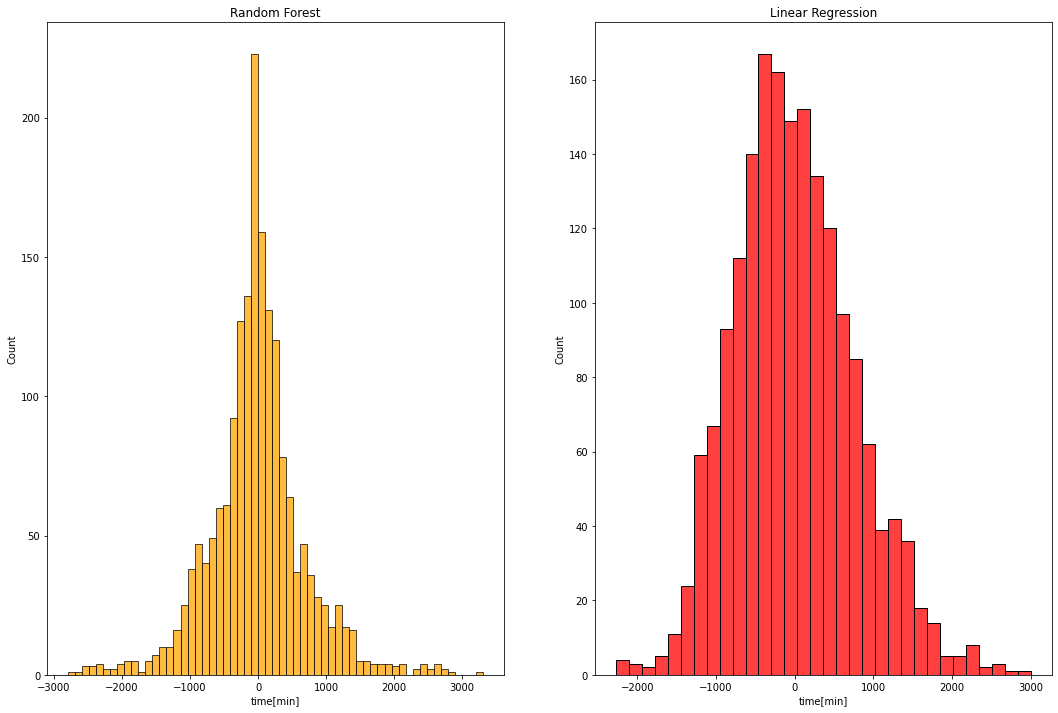

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2,figsize=(18,12))

axes[0].set_title("Random Forest")
axes[1].set_title("Linear Regression")

sns.histplot(y_test - pred_test_rand, ax = axes[0], color="orange")
sns.histplot(y_test - pred_test_reg, ax = axes[1], color= "red")

In [43]:
import pickle
with open("random_forest.pkl", "wb") as f:
  pickle.dump( reg, f)